In [1]:
import numpy as np
import pandas as pd
import random
import itertools
import math
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import minimize, Parameters, report_fit

In [2]:
#Load and prepare data
PATH_TO_DATA='../../Data/Matthews2017/Digitized/PD/'
data_05mg = pd.read_csv(PATH_TO_DATA+'PD_05mg.csv')
data_1mg = pd.read_csv(PATH_TO_DATA+'PD_1mg.csv', sep=';')
data_2mg = pd.read_csv(PATH_TO_DATA+'PD_2mg.csv')
data_10mg = pd.read_csv(PATH_TO_DATA+'PD_10mg.csv')
data_30mg = pd.read_csv(PATH_TO_DATA+'PD_30mg.csv')

data_05mg = data_05mg.dropna(axis='columns')
data_1mg = data_1mg.dropna(axis='columns')
data_2mg = data_2mg.dropna(axis='columns')
data_10mg = data_10mg.dropna(axis='columns')
data_30mg = data_30mg.dropna(axis='columns')

data_05mg.columns = ['time','change']
data_1mg.columns = ['time','change']
data_2mg.columns = ['time','change']
data_10mg.columns = ['time','change']
data_30mg.columns = ['time','change']

data_05mg = data_05mg.apply(lambda v: v.str.replace(',','.')).astype('float')
data_1mg = data_1mg.apply(lambda w: w.str.replace(',','.')).astype('float')
data_2mg = data_2mg.apply(lambda x: x.str.replace(',','.')).astype('float')
data_10mg = data_10mg.apply(lambda y: y.str.replace(',','.')).astype('float')
data_30mg = data_30mg.apply(lambda z: z.str.replace(',','.')).astype('float')

datalist = [data_10mg, data_30mg, data_2mg, data_1mg, data_05mg]
data = pd.concat(datalist) #assembled data

t_observed = []; z_observed = []
for d in range(len(datalist)):
    t_observed.append(datalist[d].time.tolist())
    z_observed.append(datalist[d].change.tolist())

In [3]:
#Viral dynamics parameters
CL = 23
lambdaT = 2e9
deltaT = 0.02
deltaT1 = 0.5
deltaT2 = 1.4
deltaPICT = 0.35
kT = 0.35
betaT0 = 8e-12
NThat = 1000
NT = 670  #NT = 0.67*NThat
NTdiff = NThat-NT

lambdaM = 6.9e7
deltaM = 0.0069; deltaM1 = 0.0069
deltaM2 = 0.09
deltaPICM = 0.0035
kM = 0.07
betaM0 = 1e-13
NMhat = 100
NM = 67
NMdiff = NMhat-NM


#Steady States
Tu0 = 20521975484.695423
T10 =  1871843034.3127716
T20 =  467974209.5123621
V0 = 13690540081.832031
VNI0 =  6834284839.026645

Mu0 =  6764846776.601595
M10 =  111822300.88519625
M20 =  84484727.48236099

In [4]:
m = 1 #fixed value

#Estimated PK parameters
hour = 24
ka = 45.4382*hour
k10 =  0.2355*hour
k12 =  0.175*hour
k21 =  0.0259*hour
Vc =  162.690 #mL
k13 = 44.2394*hour
k30 = 0.00975*hour

In [5]:
def eta(D):
    return D**m/(IC50**m + D**m)
    
def betaT(D):
    return betaT0*(1-eta(D))
                
def CLT(D):
    return (1 + eta(D))*betaT0

def betaM(D):
    return betaM0*(1-eta(D))
                
def CLM(D):
    return (1 + eta(D))*betaM0


def ode_complex(t, z, params):
    global IC50 
    IC50 = params['IC50'].value #parameter to estimate
    Tu = z[0]; T1 = z[1]; T2 = z[2]; V = z[3] #T-cells and free infectious viruses
    Mu = z[4]; M1 = z[5]; M2 = z[6]; VN = z[7] #Macrophages and non-infectious viruses
    Z0 = z[8]; Z1 = z[9]; Z2 = z[10]; Z3 = z[11] 
    #Viral dnymacics model
    dTu = lambdaT - deltaT*Tu - betaT(Z3)*V*Tu + deltaPICT*T1
    dMu = lambdaM - deltaM*Mu - betaM(Z3)*V*Mu + deltaPICM*M1
    dT1 = betaT(Z3)*V*Tu - (deltaT1 + kT + deltaPICT)*T1
    dM1 = betaM(Z3)*V*Mu - (deltaM1 + kM + deltaPICM)*M1
    dT2 = kT*T1 - deltaT2*T2
    dM2 = kM*M1 - deltaM2*M2 
    dV = NM*M2 + NT*T2 - V*(CL + (betaT(Z3)+CLT(Z3))*Tu + (CLM(Z3) + betaM(Z3))*Mu)
    dVN = (NTdiff*T2 + NMdiff*M2) - CL*VN
    #Compartment model
    dZ0 = -ka*Z0
    dZ1 = (ka/Vc)*Z0 - k10*Z1 - k12*Z1 + k21*Z2
    dZ2 = k12*Z1 - k21*Z2
    dZ3 = k13*Z1 - k30*Z3
    d = [dTu,dT1,dT2,dV,dMu,dM1,dM2,dVN,dZ0,dZ1,dZ2,dZ3]
    return d

def solve_ode(z0, data_mat, params):
    '''
    Solve the ODE-system for
        z0 = initial state of the system
        data_mat = assembled data set
        params = parameters to estimate
    
    return deltaCV
        deltaCV = Change from Baseline HIV-1 RNA (viral load)
    '''
    deltaCV=[]
    ind = data_mat.index.tolist() #get indices
    offset=0 #each data set is continuously numbered
    for j in range(len(z0)): #for each data set
        i=0
        while (ind[i+offset] == i): #while index euqlas offset
            i+=1
            if i+offset > len(ind)-1: #break if end of list is reached
                break
        offset+=i #add current index to offset
        t_obs = data_mat.time[offset-i:offset].tolist()
        res = solve_ivp(ode_complex, (tstart,max(t_obs)), z0[j], t_eval=t_obs,args=(params,))
        V_total = res.y[3]+res.y[7] #total number of viruses
        deltaCV.append(np.log10(V_total/V_total[0])) #total number divided by initial number of viruses
    return list(itertools.chain.from_iterable(deltaCV))

def solve_ode_simple(z0, t_obs, params): #calculate viral load for a single data set
    deltaCV=[]
    res = solve_ivp(ode_complex, (tstart,tfinal), z0, t_eval=t_obs, args=(params,))
    V_total = res.y[3]+res.y[7]
    deltaCV.append(np.log10(V_total/V_total[0]))
    return list(itertools.chain.from_iterable(deltaCV))

def solve_ode_single(z0, t_obs, params): #solve ode for a single data set
    z = z0
    res = solve_ivp(ode_complex, (tstart,tfinal), z, t_eval=t_obs, args=(params,))
    return res

def residual(params, z0, data_mat):
    deltaCV = solve_ode(z0, data_mat, params) #calculate viral load
    return np.power(np.subtract(deltaCV,data.change.tolist()),2)

def new_params():
    global parameters
    vIC50max = 600 #upper bound
    vIC50 = random.uniform(0,vIC50max) #randomly sample from parameter space
    parameters = Parameters()
    parameters.add('IC50', value = vIC50, min = 0, max = vIC50max)

In [8]:
dose = [10, 30, 2, 1, 0.5] #ISL doses (mg)
tstart = 0 #initial time of the system

z0 = [] #generate initial state of the system for different doses
for i in range(len(dose)):
    z0.append([Tu0, T10, T20, V0, Mu0, M10, M20, VNI0, dose[i]*3410, 0, 0, 0])
    

In [ ]:
count = 0; maxcount = 5 #initial and maximal number of iterations
IC50List = []; m = 1
aicList = []; rssList = []
while count < maxcount:
    new_params() #sample parameter
    result = minimize(residual, parameters, args=(z0, data), method = 'leastsq') #Levenberg-Marquardt algorithm
    #report_fit(result)
    rss = np.sum(residual(result.params,z0,data))        
    #print('count = ',count+1,' AIC = ',result.aic,' RSS = ',RSS)
    aicList.append(result.aic)
    IC50List.append(result.params['IC50'].value)
    rssList.append(rss)   
    count += 1

In [9]:
#Evaluation
dfResult = pd.DataFrame(list(zip(aicList,rssList,IC50List)),
                        columns =['AIC','RSS', 'IC50']) 
print(); print(dfResult)

#dfResult.to_excel('pkplasma_ic50_it50.xlsx') #store results


          AIC       RSS        IC50
0 -272.543538  0.276999  458.451638
1 -272.543537  0.276999  458.448804
2 -272.543537  0.276999  458.448703
3 -272.543538  0.276999  458.453056
4 -272.543537  0.276999  458.448871


0.27699901588001713


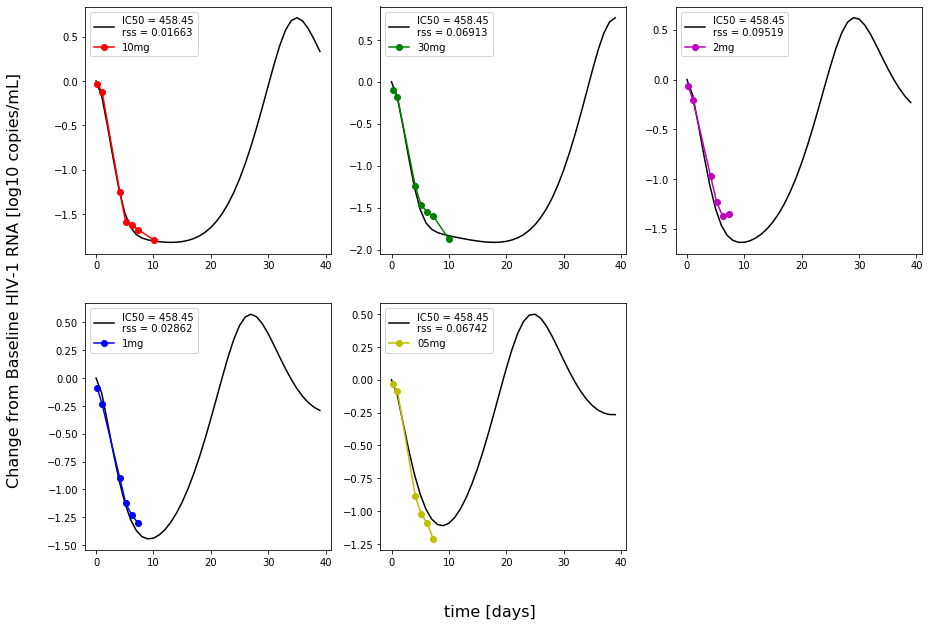

In [11]:
#Plot results
tstart = 0; tfinal=40

#Estimated parameter
ic50 = 458.45

parameters = Parameters()
parameters.add('IC50', value= ic50, vary = False)

fig, axs = plt.subplots(2,3, figsize=(15, 10), facecolor='w', edgecolor='k')

l = ['10mg', '30mg', '2mg', '1mg', '05mg'] #label
c = ['ro-', 'go-', 'mo-', 'bo-', 'yo-'] #color
axs = axs.ravel()

rsslist = []
for i in range(len(datalist)):
    res_all = solve_ode_simple(z0[i], range(tfinal), parameters)
    res = solve_ode_simple(z0[i], datalist[i].time.tolist(), parameters)
    rss = np.sum(np.power(np.subtract(res,datalist[i].change.tolist()),2))
    rsslist.append(rss)
    axs[i].plot(range(tfinal), res_all, color='black', label='IC50 = '+str(parameters['IC50'].value)+'\nrss = '+str(round(rss,5)))
    axs[i].plot(datalist[i].time.tolist(), datalist[i].change.tolist(), c[i], label=l[i])
    axs[i].legend()

fig.delaxes(ax= axs[5]) 
fig.text(0.5, 0.04, 'time [days]', ha='center', va='center', fontsize=16);
fig.text(0.06, 0.5, 'Change from Baseline HIV-1 RNA [log10 copies/mL]', ha='center', va='center', rotation='vertical', fontsize=16);
print(np.sum(rsslist))

In [ ]:
#plot single data set
x0 = [Tu0, T10, T20, V0, Mu0, M10, M20, VNI0, 1*3410, 0, 0, 0]

tstart = 0; tfinal=40

#Estimated parameter
ic50 = 458.45

parameters = Parameters()
parameters.add('IC50', value= ic50, vary = False)

res_all = solve_ode_simple(x0, range(tfinal), parameters)
res = solve_ode_simple(x0, datalist[3].time.tolist(), parameters)
plt.plot(range(tfinal), res_all, color='black')
plt.plot(datalist[3].time.tolist(), datalist[3].change.tolist(), 'ro-')
plt.xlabel('days after treatment initiation', fontsize=16)
plt.ylabel('virus load [RNA copies/mL]', fontsize=16)
plt.show()

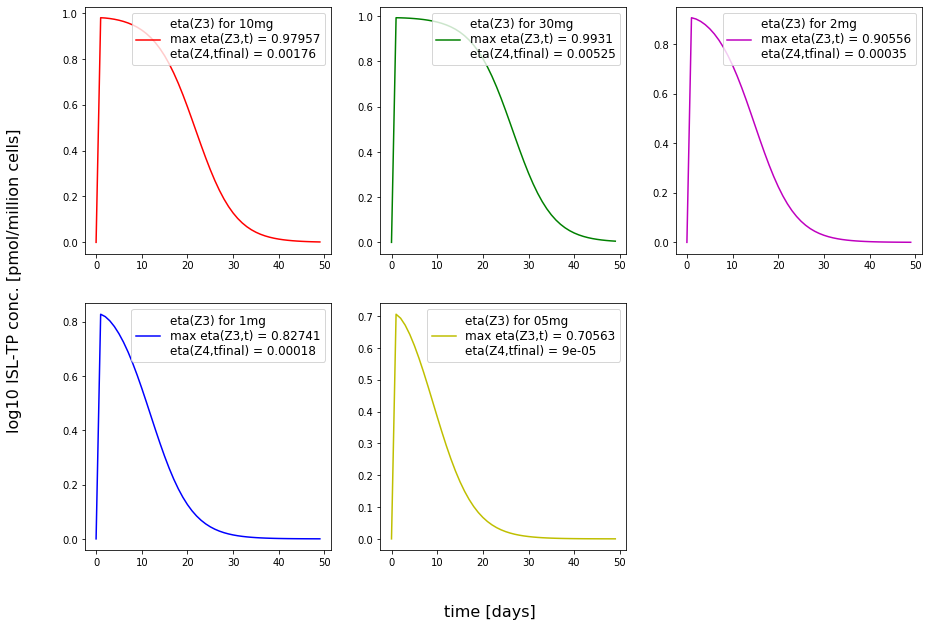

In [17]:
#plot direct drug effect
tstart = 0; tfinal=50

#Estimated parameter
ic50 = 458.45

parameters = Parameters()
parameters.add('IC50', value= ic50, vary = False)

fig, axs = plt.subplots(2,3, figsize=(15, 10), facecolor='w', edgecolor='k')

l = ['10mg', '30mg', '2mg', '1mg', '05mg'] #label
c = ['r-', 'g-', 'm-', 'b-', 'y-'] #color
axs = axs.ravel()

for i in range(len(datalist)):
    res = solve_ode_single(z0[i], range(tfinal), parameters)
    axs[i].plot(range(tfinal), eta(res.y[11]), c[i], label='eta(Z3) for '+l[i]
                +'\nmax eta(Z3,t) = '+str(round(np.max(eta(res.y[11])),5))
                +'\neta(Z4,tfinal) = '+str(round(eta(res.y[11])[-1],5)))
    axs[i].legend(loc='upper right',fontsize=12)

fig.delaxes(ax= axs[5]) 
#fig.set_title('Concentration Intracellular Compartment')
fig.text(0.5, 0.04, 'time [days]', ha='center', va='center', fontsize=16);
fig.text(0.06, 0.5, 'log10 ISL-TP conc. [pmol/million cells]', ha='center', va='center', rotation='vertical', fontsize=16);